In [1]:
import numpy as np
import pyclesperanto_prototype as cle
cle.select_device()

<GeForce GT 750M on Platform: Apple (2 refs)>

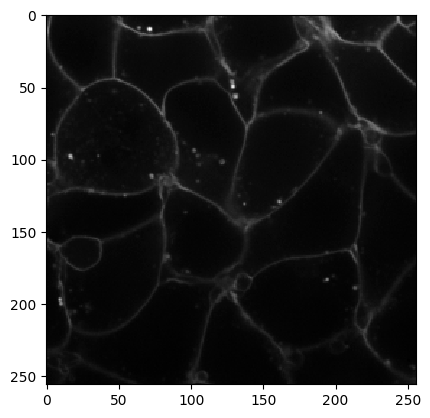

(256, 256)


In [2]:
from skimage.data import cells3d

image = cells3d()[30,0,...]
cle.imshow(image)
print(image.shape)

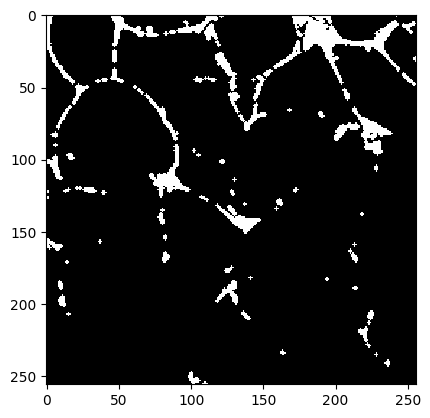

In [3]:
result_gpu = cle.morphological_snakes(image, n_iter=50, smoothing=1)
cle.imshow(result_gpu)

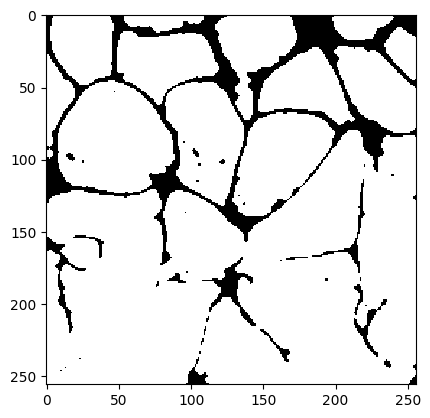

In [4]:
from skimage.segmentation import morphological_chan_vese

result_cpu = morphological_chan_vese(image, num_iter=50, smoothing=1)
cle.imshow(result_cpu)